# Gaussian Process Regression
## Part II - Kernels, Hyperparameters, and all of that...
## 2nd Machine Learning in Heliophysics
## Boulder, CO 
### 21 - 25 March 2022


### Enrico Camporeale (University of Colorado, Boulder & NOAA Space Weather Prediction Center)
#### enrico.camporeale@noaa.gov
This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.<img align="right" width="88" height="31" src=https://i.creativecommons.org/l/by/4.0/88x31.png> <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">

## Recap

\begin{equation}\boxed{\boldsymbol\mu_{a|b}=\boldsymbol\mu_a+\boldsymbol\Sigma_{ab}\boldsymbol\Sigma_{bb}^{-1}(\boldsymbol x_b - \boldsymbol\mu_b) \\ 
\boldsymbol\Sigma_{a|b} = \boldsymbol\Sigma_{aa} - \boldsymbol\Sigma_{ab}\boldsymbol\Sigma_{bb}^{-1}\boldsymbol\Sigma_{ba}} \end{equation} or 

\begin{equation}\boxed{\boldsymbol\mu_{a|b}=\boldsymbol\mu_a-\boldsymbol\Lambda_{aa}^{-1}\boldsymbol\Lambda_{ab}(\boldsymbol x_b - \boldsymbol\mu_b) \\ 
\boldsymbol\Sigma_{a|b} = \boldsymbol\Lambda_{aa}^{-1}} \end{equation}

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.sparse import spdiags
import seaborn as sns
import pandas as pd
from ipywidgets import interactive, interact_manual
import time
import matplotlib.animation as animation

plt.rcParams.update({'font.size': 26})
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Sampling from a multivariate normal distribution

Every modern programming language has built-in functions to sample from a multivariate normal distribution

Covariance matrix = 
 [[2.  0.9 0.8 0.7 0.1]
 [0.9 2.  0.9 0.8 0.7]
 [0.8 0.9 2.  0.9 0.8]
 [0.7 0.8 0.9 2.  0.9]
 [0.1 0.7 0.8 0.9 2. ]]


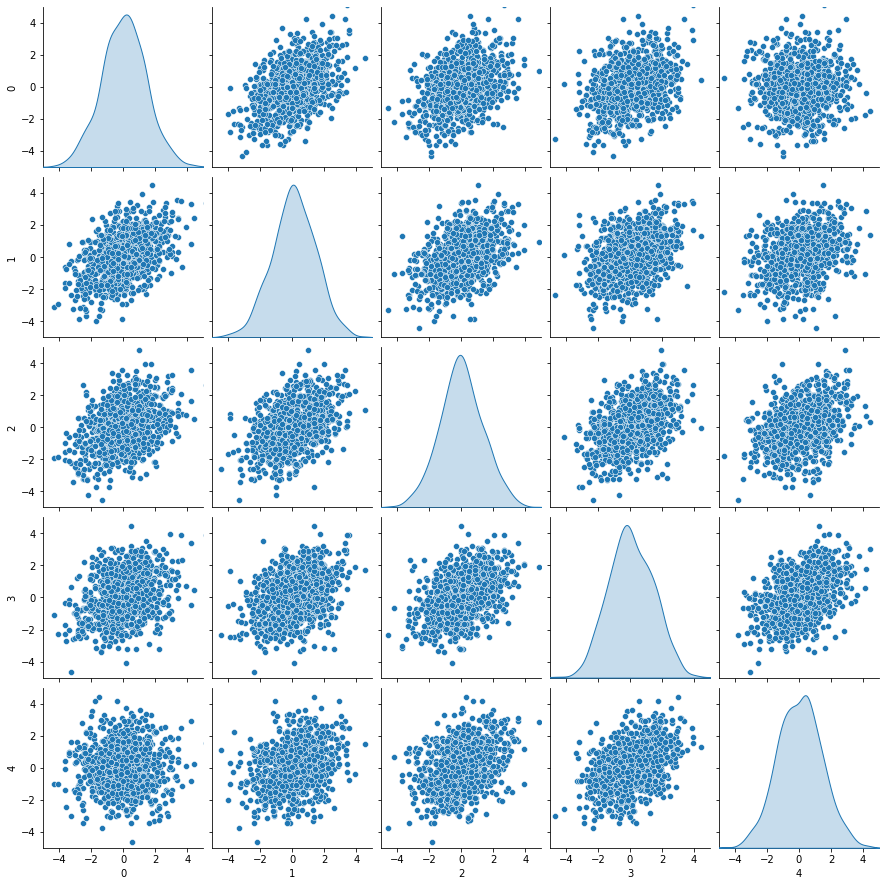

In [2]:
# define dimension
dim = 5

# define mean
mu = ([0,0,0,0,0])

# define covariance matrix
# for now let's do this 'by hand'

data = np.array([1*np.ones(dim), 0.9*np.ones(dim), 0.8*np.ones(dim), 0.7*np.ones(dim), 0.1*np.ones(dim)])
diags = np.array([0, 1, 2, 3, 4])
Sigma = spdiags(data, diags, 5, 5)
Sigma = (Sigma+ np.transpose(Sigma)).toarray()
print('Covariance matrix = \n', Sigma)
# Here we take 1000 samples from the multivariate normal with mean mu and covariance Sigma
samples = np.random.multivariate_normal(mu,Sigma,1000)

# Visualization
df = pd.DataFrame(data=samples) # transform np.array to pandas dataframe

## this is nice but slow...
#g = sns.PairGrid(df)
#g.map_diag(sns.kdeplot)
#g.map_offdiag(sns.kdeplot, n_levels=6);

## this is faster
g = sns.pairplot(df, diag_kind="kde", corner=False)
g.set(xlim=(-5,5), ylim=(-5,5))


## An alternative way of representing multidimensional samples

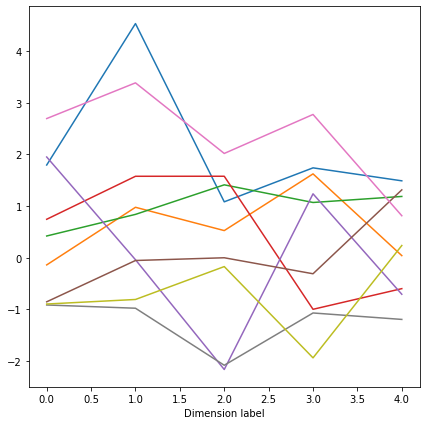

In [3]:
fig = plt.figure(figsize=(7, 7)) 
ax = fig.gca()
x = range(5) # label for the dimension

# plot 10 samples of my 5-dimensional distribution
plt.plot(x, np.transpose(samples[1:10,:]))  
ax.set_xlabel('Dimension label')
plt.show()

Each dimension is strongly correlated with the adjacent but the correlation decreases with the dimension distance 

## Let us change the covariance between dimension 0 and dimension 1

[[2.  0.  0.8 0.7 0.1]
 [0.  2.  0.9 0.8 0.7]
 [0.8 0.9 2.  0.9 0.8]
 [0.7 0.8 0.9 2.  0.9]
 [0.1 0.7 0.8 0.9 2. ]]


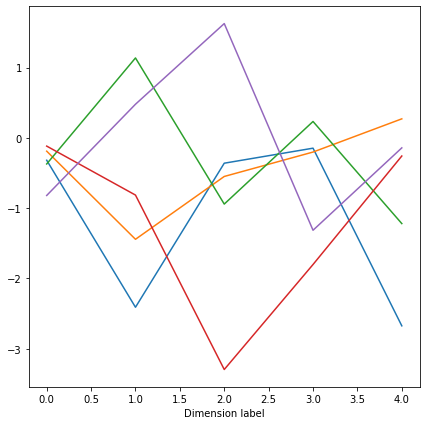

In [4]:
Sigma[0,1]=0; Sigma[1,0]=0
print(Sigma)
samples = np.random.multivariate_normal(mu,Sigma,5)

fig = plt.figure(figsize=(7, 7)) 
ax = fig.gca()
x = range(5)
plt.plot(x, np.transpose(samples[0:5,:]))
ax.set_xlabel('Dimension label')
plt.show()


# Let's move to higher dimension

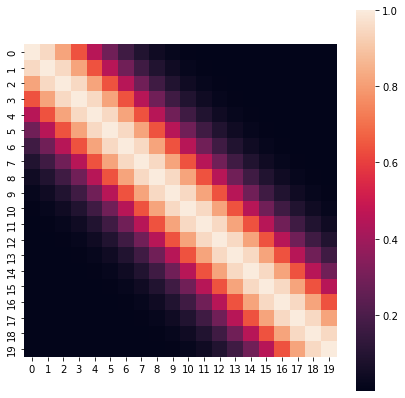

In [6]:
# Define the covariance matrix
def cov_matrix(a, b):
    """ GP squared exponential kernel """
    sigma_sq = 10
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T) # this is (a-b)^2
    return np.exp(-.5 * (1/sigma_sq) * sqdist)

# plot an example of covariance matrix in 20 dimensions

dim = 20
x=np.array(range(dim)).reshape(dim,1)
Sigma = cov_matrix(x,x)
df = pd.DataFrame(data=Sigma) # transform np.array to pandas dataframe
fig = plt.figure(figsize=(7, 7)) 
ax = fig.gca()
ax = sns.heatmap(df)
ax.set_aspect('equal')


In [7]:
def f(dim):
    x=np.array(range(dim)).reshape(dim,1)
    mu = 0.0*np.ones(dim)
    Sigma = cov_matrix(x,x)
    samples = np.random.multivariate_normal(mu,Sigma,1)

    fig = plt.figure(figsize=(7, 7)) 
    ax = fig.gca()
    plt.plot(x, np.transpose(samples))
    ax.set_xlabel('Dimension label')
    return(0)
interactive_plot = interact_manual(f, dim=(10,100))
output = interactive_plot


interactive(children=(IntSlider(value=55, description='dim', min=10), Button(description='Run Interact', style…

Again, all points are strongly correlated with the neighbours resulting in smooth curves

## What if now we take the distribution conditioned on all except one variable?


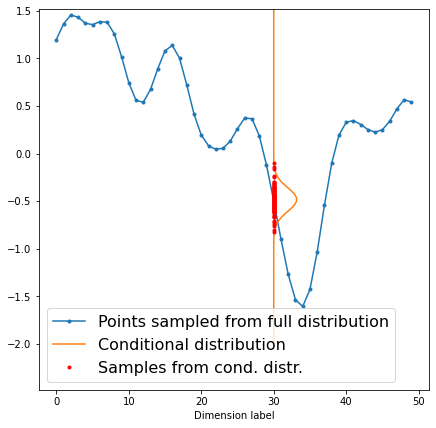

In [8]:
%matplotlib inline
# Number of dimensions
dim = 50
x=np.array(range(dim)).reshape(dim,1)

# Define covariance matrix and mean and draw one sample
Sigma = cov_matrix(x,x)
mu = 0.0*np.ones(dim)
samples = np.random.multivariate_normal(mu,Sigma,1)

# Choose one variable. We condition on all the others
dim_a = 30 # label of the variable we want to calculate the distribution of

dim_b = np.concatenate((np.arange(0,dim_a),np.arange(dim_a+1,dim))) # all variables except dim_a

Lambda = np.linalg.inv(Sigma+spdiags(1e-2*np.ones(dim), 0, dim, dim).toarray())  ## add a little noise on the main diag
Lambda_aa= Lambda[dim_a][dim_a] # this is now a scalar since we are conditioning on all except just one variable
Sigma_cond = 1/Lambda_aa  # because Lambda_aa is a scalar. This is Sigma of a conditioned on b
std = np.sqrt(Sigma_cond) # Standard deviation 

Lambda_ab = Lambda[dim_b,:][:,dim_a].reshape(1,dim-1)  # dimension 1 x (dim-1)

xb = samples[0][dim_b]

mu_ab = -np.dot(Lambda_ab,xb)/Lambda_aa # mean of a conditioned on b

# Draw 100 samples from the conditioned distribution (this is a 1D normal)
samples_1D = np.random.normal(mu_ab, std, 100)

# calculate the distribution over 100 points (for plotting)
y= np.linspace(-2,2,num=100)
f = dim_a+1/np.sqrt(2*np.pi)/std * np.exp(-0.5*(y-mu_ab)**2/std**2)

# visualization
fig = plt.figure(figsize=(7, 7))
ax = fig.gca()
ax.plot(x, np.transpose(samples),'.-',label='Points sampled from full distribution')
ax.plot(f,y,label='Conditional distribution')
ax.plot(dim_a*np.ones(100),samples_1D,'.r',label='Samples from cond. distr.')
ax.set_ylim(mu_ab-2, mu_ab+2)
ax.set_xlabel('Dimension label')
ax.legend(fontsize=16)
plt.show()

## Another example. We take out more than one variable and sample curves from the conditional distribution

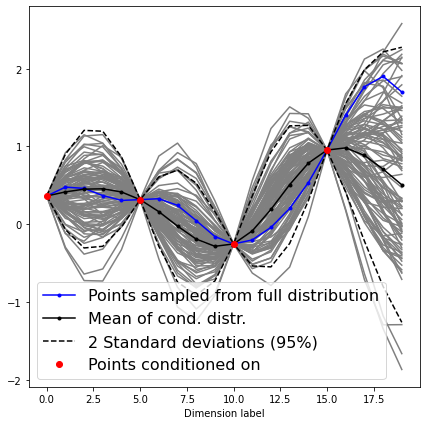

In [9]:
## %matplotlib inline
# Number of dimensions
dim = 20
x=np.array(range(dim)).reshape(dim,1)
Sigma = cov_matrix(x,x)
mu = 0.0*np.ones(dim)

samples = np.random.multivariate_normal(mu,Sigma,1)
dim_a = np.arange(0,dim)

# Choose a set of variables dim_b on which we condition the distribution
dim_b = np.arange(0,dim,5)

Sigma_aa= Sigma[dim_a,:][:,dim_a]
Sigma_ab= Sigma[dim_a,:][:,dim_b]
Sigma_ba= Sigma[dim_b,:][:,dim_a] # This is really just the transpose of Sigma_ab !!
Sigma_bb= Sigma[dim_b,:][:,dim_b]

xb = samples[0][dim_b]

# GP Algorithm
z = np.linalg.solve(Sigma_bb, xb)
mu_ab = np.matmul(Sigma_ab,z)

z = np.linalg.solve(Sigma_bb, Sigma_ba)
Sigma_cond = Sigma_aa - np.matmul(Sigma_ab,z)
 
V = np.sqrt(np.diag(Sigma_cond)) # Standard deviation

#Visualization
fig = plt.figure(figsize=(7, 7))
ax = fig.gca()
samples_1D = np.transpose(np.random.multivariate_normal(mu_ab,Sigma_cond,100))
ax.plot(dim_a,samples_1D,'',color='grey')
ax.plot(x, np.transpose(samples),'.-b',label='Points sampled from full distribution')
ax.plot(dim_a,mu_ab, 'k.-', label='Mean of cond. distr.')
ax.plot(dim_a,mu_ab+2*V, 'k--', label='2 Standard deviations (95%)')
ax.plot(dim_a,mu_ab-2*V, 'k--', )

ax.plot(dim_b,np.transpose(samples[:,dim_b]),'or', label='Points conditioned on')
ax.set_xlabel('Dimension label')
ax.legend(fontsize=16)
plt.show()



## The aha! moment

We now have a recipe to construct multivariate normal distribution conditional on a subset of variables. The recipe is fully analytical and relies on linear algebra only.
Most importantly, the mean and covariance of the conditional distribution are known in closed form.



_Nonlinear regression task (1D)_: we have a number of observations/data $D$ for which we know corresponding input/output: $\{x_1,y_1\},\{x_2,y_2\},\ldots,\{x_D,y_D\}$

We want to find the function $f(x)$ that generalizes the input/output relationship, assuming that $y=f(x)+\varepsilon$  
 

D observations $\longrightarrow$ $D-$dimensional multivariate Gaussian

Dimensional label $i\longrightarrow x_i$

Value sampled for the dimension $i\longrightarrow y_i$


### What else do we need to be able to use this formalism for nonlinear regression?

+ Our input data is not an integer (ie we need to be able to construct functions $y=f(x)$ for a real-valued x
+ We need the covariance matrix between observations and observations
+ We need the covariance matrix between observations and predictions
+ We need the covariance matrix between predictions and predictions

Remember that $cov(x,y)=\mathbb{E}( (x-\mathbb{E}(x))(y-\mathbb{E}(y)) = \mathbb{E}(xy)-\mathbb{E}(x)\mathbb{E}(y)$


# We need a Covariance function (aka Kernel) !!

# Covariance functions


## Reference: http://www.gaussianprocess.org/gpml/chapters/RW4.pdf

A Covariance function is the crucial ingredient in GP regression, because it encodes all of our assumptions about the underlying functions we are trying to learn

A general name for a function $k$ of two arguments mapping a pair of inputs $x\in \mathcal{X} , x'\in \mathcal{X}\rightarrow\mathcal{R}$ is a <strong>kernel</strong>. 

Not any generic kernel is a valid covariance function. The main constraint it has to satisfy is that the Covariance matrix generated must be positive semi-definite (all its eigenvalues are positive).



# The most important concept in Gaussian Process Regression

### We assume that the covariance between two data points $(x_1,y_1)$ and $(x_2,y_2)$ is a function of their inputs (in general multidimensional):

$$\boxed{cov(y_1,y_2) = k(x_1,x_2)}$$

Because the covariance encodes the _similarity_ between data points, this is a statement about similar inputs having similar outputs. 

Also, <strong>assuming</strong> the covariance function to be of a given pre-defined functional form allows us to contruct the full Covariance Matrix $\boldsymbol\Sigma$ where each element is defined as:

$\Sigma_{ij}=k(x_i,x_j)$

Once again: the Covariance Matrix entries are only functions of the inputs $x$, not the outputs $y$. This is how we can construct also the elements corresponding to unseen data (predictions)

## Stationary Covariance Functions

Because we want to encode the _similarity_ between the output $y_1$ observed at $x_1$ and the output $y_2$ observed at $x_2$, it makes sense to use a kernel that is a function of the distance $|x_1-x_2|$ only.

Those are called Stationary Covariance Functions

### Squared Exponential Covariance Function (or Radial Basis Function, RBF)

$r=x_1-x_2$

$k(x_1,x_2) = \sigma\exp\left(-\frac{r^2}{l^2}\right)$  (defined and used here at the top of the notebook)

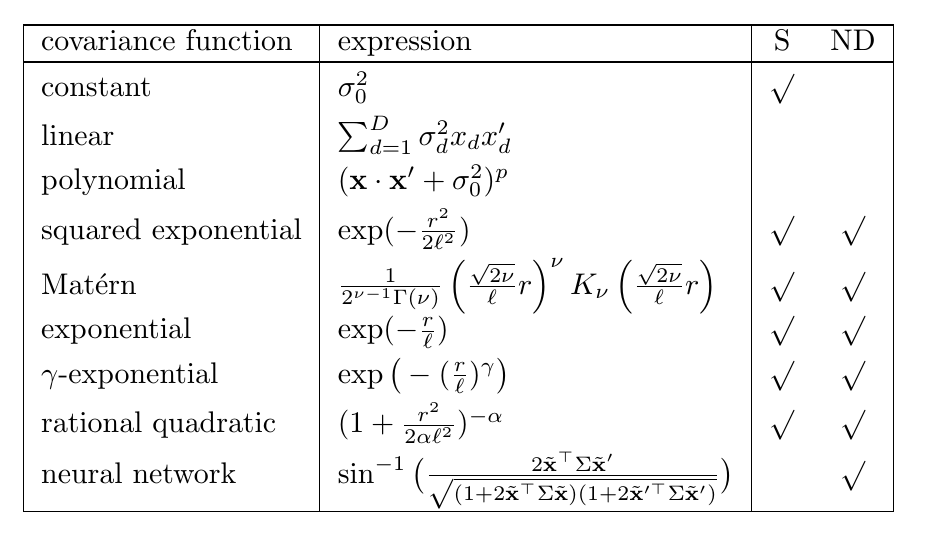
From C. E. Rasmussen &ISBN 026218253X.C. K. I. Williams, Gaussian Processes for Machine Learning, the MIT Press, 2006, www.GaussianProcess.org/gpml


### Hyperparameters

Most covariance functions depend on some free parameters, called Hyperparameters.

For instance the squared exponential function has (in 1D) two free parameters: $\sigma$ and $l$.

$k(x_1,x_2) = \sigma\exp\left(-\frac{(x_1-x_2)^2}{l^2}\right)$



### Role of hyperparameters

In [10]:
# Define the covariance matrix
def cov_matrix(a, b, sigma, l):
    """ GP squared exponential kernel """
    l_sq = l**2
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T) # this is (a-b)^2
    return sigma*np.exp(-.5 * (1/l_sq) * sqdist)

# dimensions
dim = 20

def f(sigma,l):
    x=np.array(range(dim)).reshape(dim,1)
    mu = 0.0*np.ones(dim)
    Sigma = cov_matrix(x,x,sigma,l)
    samples = np.random.multivariate_normal(mu,Sigma,1)
#    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(7, 7))
#    fig = plt.figure() 
#    ax = fig.gca()
    fig = plt.figure(figsize=(15,4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.plot(x, np.transpose(samples))
    ax1.set_xlabel('Dimension label')
    df = pd.DataFrame(data=Sigma) # transform np.array to pandas dataframe
    ax2 = sns.heatmap(df)
    ax2.set_aspect('equal')

    return(0)
interactive_plot = interactive(f, sigma=(1,10),l=(0.1,10))
output = interactive_plot.children[-1]
interactive_plot


interactive(children=(IntSlider(value=5, description='sigma', max=10, min=1), FloatSlider(value=5.05, descript…

## How do we choose the hyperparameters?

### We fit the data!

That is, we choose the hyperparameters that when used in the kernel generate a covariance matrix that is most consistent with the observed data.

Basically, we try to answer the following: given a functional form for the the covariance function, what are the hyperparameters such that our data is likely to be generated as a sample from the resulting D-dimensional Gaussian distribution ?

This turns out to be an optimization problem, where we want to maximize the probability associated to the data (one sample from the distribution). This is the <strong> training </strong> phase of a GP

# Gaussian Process

## ... and finally a definition:

### A Gaussian Process is a collection of random variables, any finite number of which have a joint Gaussian distribution. It can be thought as a generalization of a Gaussian distribution that works over functions.

A Gaussian Process is completely specified by its mean and covariance.

Mean function $m(\boldsymbol{x}) = \mathbb{E}(f(x)))$ 

Covariance function $k(\boldsymbol x_i, \boldsymbol x_j) = \mathbb{E}[(f(\boldsymbol x_i) -m(\boldsymbol x_i))(f(\boldsymbol x_j) -m(\boldsymbol x_j))]$

This is usually specified as $f(\boldsymbol x)\sim\mathcal{GP}(m(\boldsymbol x),k)$

## Cookbook

$ y(\boldsymbol x) = f(\boldsymbol x) + \varepsilon$

We have $D$ data points $(\boldsymbol x_i,y_i)$


We use the shortcut $f_* = f(\boldsymbol x_*) $ for (unknown) predicted values for input $\boldsymbol x_*$   

We assume that the joint distribution of observed and unobserved values is Gaussian:

$\begin{bmatrix} y \\ f_* \end{bmatrix}\sim\mathcal{N}\left(\boldsymbol 0,\begin{bmatrix} k(\boldsymbol x,\boldsymbol x) & k(\boldsymbol x,\boldsymbol x_*) \\ k(\boldsymbol x_*,\boldsymbol x) & k(\boldsymbol x_*,\boldsymbol x_*)\end{bmatrix}\right)$

Note that a mean $m(\boldsymbol x)=0$ is typically chosen when no further information is available. This choice does not assume anything about the data and holds upon shifting (ie subtract the mean).

1) Choose a kernel that encodes our information about the data

2) Optimize the hyperparameters to fit the data

3) Construct the Covariance matrix

4) Calculate mean and (if you want to estimate the uncertainty) standard deviation at the inputs $\boldsymbol x_*$ using:

\begin{equation}\boldsymbol\mu_{a|b}=\boldsymbol\mu_a+\boldsymbol\Sigma_{ab}\boldsymbol\Sigma_{bb}^{-1}(\boldsymbol x_b - \boldsymbol\mu_b) \\ 
\boldsymbol\Sigma_{a|b} = \boldsymbol\Sigma_{aa} - \boldsymbol\Sigma_{ab}\boldsymbol\Sigma_{bb}^{-1}\boldsymbol\Sigma_{ba} \end{equation} 


## Computational considerations

The algorithm involves inverting the matrix $\Sigma_{bb}$, which is the partition of the covariance matrix $k(x,x)$ (the observed data). This means that the method does not scale well with large number of datapoints.

Also, $\Sigma_{bb}$ might be ill-conditioned, meaning that its inverse can be computationally unstable. This is typically fixed by adding a small noise terms to the diagonal, which can be interpreted as a Gaussian noise term $\varepsilon$ on the observations.
Techniques have been developed to accelerate GPs, based on computing sparse approximation of the covariance matrix.



## Numerical algorithm (zero mean)

$$\begin{equation}\boldsymbol\mu_{f_*|y}=\boldsymbol k(x_*,x)\boldsymbol k(x,x)^{-1} \boldsymbol y \\ 
\boldsymbol\Sigma_{f_*|y} = \boldsymbol k(x_*,x_*) - \boldsymbol k(x_*,x) \boldsymbol k(x,x)^{-1} \boldsymbol k(x,x_*) \end{equation}$$

inputs: $\boldsymbol x$(inputs), $\boldsymbol  y$(targets), $\boldsymbol k$ (covariance function), $\sigma^2$ (noise level), $x_∗$ (test input)

outputs: $f_*$ (output)

We make use of the Cholesky decomposition to solve for $\boldsymbol k(x,x)^{-1} \boldsymbol y$

$\boldsymbol L\boldsymbol L^T =\boldsymbol k(x,x)+\sigma^2I$

Using an auxilary variable $\boldsymbol z = \boldsymbol k(x,x)^{-1}\boldsymbol  y$:

solve: $\boldsymbol L(\boldsymbol L^T \boldsymbol z) = \boldsymbol y$ 

$\boldsymbol f_* = \boldsymbol k(x_*,x)\cdot \boldsymbol z$

solve $\boldsymbol L \boldsymbol v=\boldsymbol k(x,x_*)$

full covariance matrix $\rightarrow\boldsymbol \Sigma_{f_*|y} = \boldsymbol k(x_*,x_*) -\boldsymbol v^T\boldsymbol v$


## Why non-parametric?

## And why the assumption that the data is drawn from a multivariate normal distribution makes sense ?

### A quick connection to Bayesian linear regression

In linear regression we have:  $y = \boldsymbol{w}^T\boldsymbol{x} + \varepsilon$, with $\varepsilon\sim\mathcal{N}(0,\sigma^2)$.

$P(y|x,w) \sim \mathcal{N}(\boldsymbol{w}^T\boldsymbol{x},\sigma^2)$

If we now assume that $P(w|Data) \sim\mathcal{N}(0,S)$ (is a Gaussian) we can derive the $P(y|x,Data)$ by marginalizing out the weights $w$:

$P(y|x,Data) = \int P(y|x,w,Data)P(w|Data) dw$

Therefore we have integrated over all possible values of $w$.

Non-parametric == infinite number of parameters

The assumptions of $P(w|Data)$ and $\varepsilon$ being Gaussian then imply that $P(y|x,Data)$ is Gaussian as well.

<strong>The GP regression approach starts directly from this assumption</strong>, with no prior model (linear or not) assumed


## Advanced topics


### Warped Gaussian Process (generalization to non-Gaussian distributions)

### Deep Gaussian Process 

### GP with Heteroskedastic noise

### GP with physics-based kernels

# End of Part 2